In [3]:
import h5py, os, glob
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from imp import reload

from noise_correlations.data import datasets
from noise_correlations import discriminability, null_models
from noise_correlations.discriminability import lfi_data, lda_data, corrected_lfi_data, mv_normal_jeffreys_data
from noise_correlations.null_models import random_rotation_data, shuffle_data
from noise_correlations import plot

In [2]:
# data paths
fname = 'nc_datasets/R32_B7_MUAR_ext_rsp.h5'
with h5py.File(fname, 'r') as f:
    resp = f['final_rsp'].value
n_el, n_samples, n_freq, n_attn = resp.shape
Yp = np.transpose(resp[..., 5], axes=(0, 2, 1))
trial_medians = np.median(Yp, axis=-1)
keep = (trial_medians.max(axis=1) / trial_medians.min(axis=1)) >= 5.
Yp = Yp[keep]
bfs = np.median(Yp, axis=-1).argmax(axis=1)
idxs = np.argsort(bfs)
bfs = bfs[idxs]
Yp = Yp[idxs]
n_el, n_freq, n_samples = Yp.shape

/Users/jesse/anaconda3/envs/noise_correlations/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [3]:
Yp.shape

(33, 30, 20)

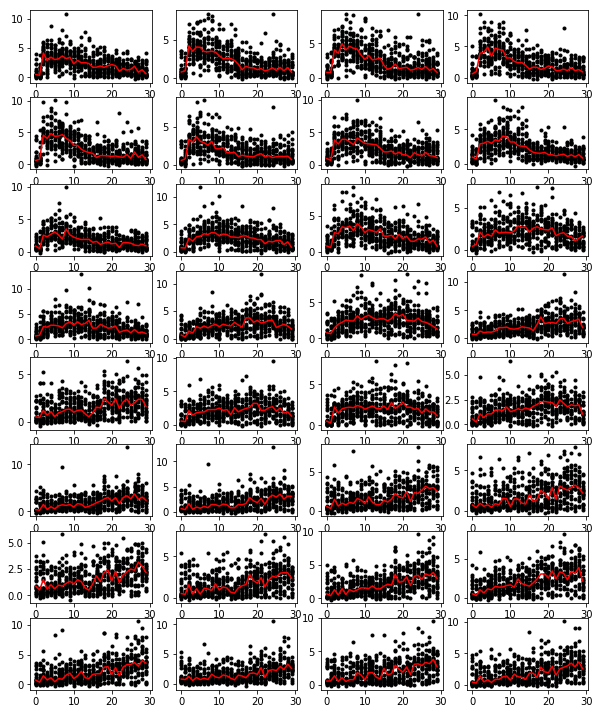

In [51]:
fig, axes = plt.subplots(Yp.shape[0]//4, 4, figsize=(10, 12.5))
for ax_idx, ax in enumerate(axes.ravel()):
    counts = Yp[ax_idx]
    freqs = np.tile(np.arange(n_freq)[:, np.newaxis], (1, Yp.shape[-1]))
    ax.scatter(freqs, counts, marker='.', color='k')
    ax.plot(np.median(freqs, axis=1), np.median(counts, axis=1), color='r')

In [4]:
delta_fs = 2
delta_es = 2
n_boot = 10000

n_pts = 0
for ii in range(n_el - 2):
    for d in range(delta_es):
        n0 = ii
        n1 = ii + d + 1
        minf = max(0, bfs[n0] - delta_fs)
        maxf = min(n_freq - 1, bfs[n1] + delta_fs + 1)
        n_pts += maxf - minf
print(n_pts)
    
ps = np.full((2, 2, n_pts), np.nan)
idx = 0
for ii in range(n_el - 2):
    print(float(idx) / n_pts)
    for d in range(delta_es):
        n0 = ii
        n1 = ii + d + 1
        minf = max(0, bfs[n0] - delta_fs)
        maxf = min(n_freq - 1, bfs[n1] + delta_fs + 1)
        for f in range(minf, maxf):
            x = Yp[[n0, n1]][:, f].T
            y = Yp[[n0, n1]][:, f + 1].T
            val_s, values_s, ps_s = null_models.eval_null_data(x, y, shuffle_data,
                                                               [lfi_data, mv_normal_jeffreys_data], n_boot)
            val_r, values_r, ps_r = null_models.eval_null_data(x, y, random_rotation_data,
                                                               [lfi_data, mv_normal_jeffreys_data], n_boot)
            ps[0, :, idx] = ps_s
            ps[1, :, idx] = ps_r
            idx += 1

356
0.0
0.033707865168539325
0.07303370786516854
0.10112359550561797
0.12921348314606743
0.16853932584269662
0.21910112359550563
0.24719101123595505
0.2752808988764045
0.30337078651685395
0.34269662921348315
0.398876404494382
0.44662921348314605
0.4943820224719101
0.5280898876404494
0.5561797752808989
0.5870786516853933
0.6235955056179775
0.6657303370786517
0.7191011235955056
0.7640449438202247
0.7921348314606742
0.8202247191011236
0.848314606741573
0.8707865168539326
0.8932584269662921
0.9157303370786517
0.9325842696629213
0.949438202247191
0.9662921348314607
0.9831460674157303


In [5]:
np.savez('ps_max', ps=ps)

Bbox(x0=0.125, y0=0.125, x1=0.47727272727272724, y1=0.88)
sig shuffle:  0.33707865168539325
sig rotate:  0.07865168539325842
only sig shuffle:  0.2612359550561798
only sig rotate:  0.0028089887640449437
sig both:  0.07584269662921349

sig shuffle:  0.0
sig rotate:  0.0
only sig shuffle:  0.0
only sig rotate:  0.0
sig both:  0.0



/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher

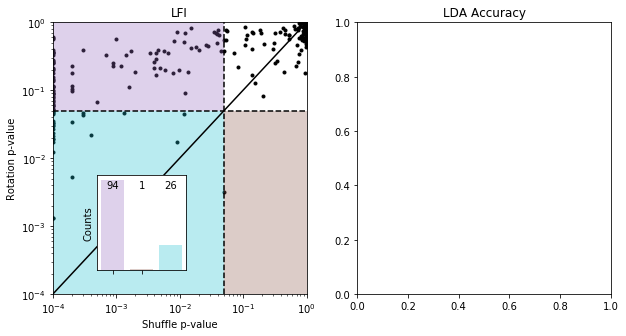

In [21]:
reload(plot)
faxes = plt.subplots(1, 2, figsize=(10, 5))
f, (ax0, ax1) = faxes
plot.plot_pvalue_comparison(ps[0, 0].ravel(), ps[1, 0].ravel(),
                           labels=['Shuffle p-value', 'Rotation p-value'], faxes=(f, ax0))
#plot.plot_pvalue_comparison(ps[0, 1].ravel(), ps[1, 1].ravel(),
#                       labels=['Shuffle p-value', 'Rotation p-value'], faxes=(f, ax1))
ax0.set_title('LFI')
ax1.set_title('LDA Accuracy')
#plt.savefig('/home/jesse/Downloads/maxd.pdf')

for ii in range(2):
    print('sig shuffle: ', (ps[0, ii] <= .05).sum() / ps[0, ii].size)
    print('sig rotate: ', (ps[1, ii] <= .05).sum() / ps[1, ii].size)
    print('only sig shuffle: ', (np.logical_and(ps[0, ii] <= .05, ps[1, ii] > .05)).sum() / ps[0, ii].size)
    print('only sig rotate: ', (np.logical_and(ps[1, ii] <= .05, ps[0, ii] > .05)).sum() / ps[0, ii].size)
    print('sig both: ', (np.logical_and(ps[0, ii] <= .05, ps[1, ii] <= .05)).sum() / ps[0, ii].size)
    print()